# Project 7

## Assignment Scenario

You are a data scientist in an entertainment company. You are given a MovieLens dataset. It includes around 1 million ratings from 6000 users on 4000 movies, along with some user features, movie genres. In addition, the timestamp of each user-movie rating is provided, which allows creating sequences of movie ratings for each user, as expected by the BST model.

You are asked to develop a Transformer-based recommendation system using the attached Jupyter Notebook and writing a script in Python, and running all the cells. You only need to submit a JupyterNotebook. 

Data Source: MovieLens from an external site.

 

**Steps and Questions:**

Please modify the sample codesLinks to an external site. at Keras' official website.

1. Download and prepare the dataset.
2. Transform the movie ratings data into sequences.
3. Define metadata.
4. Create tf.data.Dataset for training and evaluation.
5. Create model inputs.
6. Create a BST model.
7. Run training and evaluation experiment.


## Load Necessary Libraries

In [1]:
import os
import random
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import StringLookup
from tensorflow.keras.callbacks import EarlyStopping

# Fix the seeds for reproducibility
SEED = 42
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Ensures determinism in cuDNN
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Importing additional libraries if needed
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Step 1: Load the Dataset

In [2]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

In [3]:
users = pd.read_csv(
    "ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
    encoding="ISO-8859-1",
    engine="python",
)

ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
    encoding="ISO-8859-1",
    engine="python",
)

movies = pd.read_csv(
    "ml-1m/movies.dat",
    sep="::",
    names=["movie_id", "title", "genres"],
    encoding="ISO-8859-1",
    engine="python",
)

In [4]:
ratings_df = ratings

movies_df = movies

users_df = users

In [5]:
# Data preprocessing to fix the data types within the columns

users_df["user_id"] = users_df["user_id"].apply(lambda x: f"user_{x}")
users_df["age_group"] = users_df["age_group"].apply(lambda x: f"group_{x}")
users_df["occupation"] = users_df["occupation"].apply(lambda x: f"occupation_{x}")

movies_df["movie_id"] = movies_df["movie_id"].apply(lambda x: f"movie_{x}")

ratings_df["movie_id"] = ratings_df["movie_id"].apply(lambda x: f"movie_{x}")
ratings_df["user_id"] = ratings_df["user_id"].apply(lambda x: f"user_{x}")
ratings_df["rating"] = ratings_df["rating"].apply(lambda x: float(x))

In [6]:
genres = ["Action", "Adventure", "Animation", "Children's", "Comedy", "Crime"]
genres += ["Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical"]
genres += ["Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

for genre in genres:
    movies_df[genre] = movies_df["genres"].apply(
        lambda values: int(genre in values.split("|"))
    )

### Ratings Dataset

In [7]:
print("Ratings Dataset:")
ratings_df.head()

Ratings Dataset:


,user_id,movie_id,rating,unix_timestamp
0,user_1,movie_1193,5.0,978300760
1,user_1,movie_661,3.0,978302109
2,user_1,movie_914,3.0,978301968
3,user_1,movie_3408,4.0,978300275
4,user_1,movie_2355,5.0,978824291


In [8]:
ratings_df.describe()

,rating,unix_timestamp
count,1.000209e+06,1.000209e+06
mean,3.581564e+00,9.722437e+08
std,1.117102e+00,1.215256e+07
min,1.000000e+00,9.567039e+08
25%,3.000000e+00,9.653026e+08
50%,4.000000e+00,9.730180e+08
75%,4.000000e+00,9.752209e+08
max,5.000000e+00,1.046455e+09


In [9]:
ratings_df.isnull().sum()/len(ratings_df)*100

user_id           0.0
movie_id          0.0
rating            0.0
unix_timestamp    0.0
dtype: float64

<Axes: xlabel='rating', ylabel='count'>

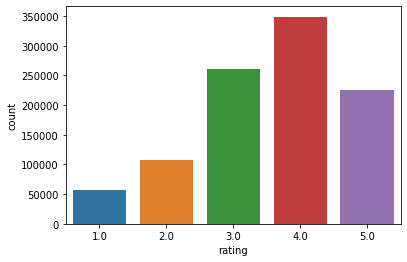

In [10]:
import seaborn as sns
sns.countplot(x= 'rating', data = ratings_df)

### Movies Dataset

In [11]:
print('Movies Dataset:')
movies_df.head()

Movies Dataset:


,movie_id,title,genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,movie_1,Toy Story (1995),Animation|Children's|Comedy,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,movie_2,Jumanji (1995),Adventure|Children's|Fantasy,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,movie_3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,movie_4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,movie_5,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
movies_df.describe()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000
mean,0.129539,0.072882,0.027041,0.064641,0.309039,0.054339,0.032707,0.412825,0.017512,0.011331,0.088334,0.029359,0.027298,0.121298,0.071079,0.126706,0.036827,0.017512
std,0.335839,0.259976,0.162224,0.245923,0.462157,0.226715,0.177891,0.492405,0.131187,0.105858,0.283816,0.168832,0.162973,0.326515,0.256990,0.332686,0.188362,0.131187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
movies_df.isnull().sum()/len(movies_df)*100

movie_id       0.0
title          0.0
genres         0.0
Action         0.0
Adventure      0.0
Animation      0.0
Children's     0.0
Comedy         0.0
Crime          0.0
Documentary    0.0
Drama          0.0
Fantasy        0.0
Film-Noir      0.0
Horror         0.0
Musical        0.0
Mystery        0.0
Romance        0.0
Sci-Fi         0.0
Thriller       0.0
War            0.0
Western        0.0
dtype: float64

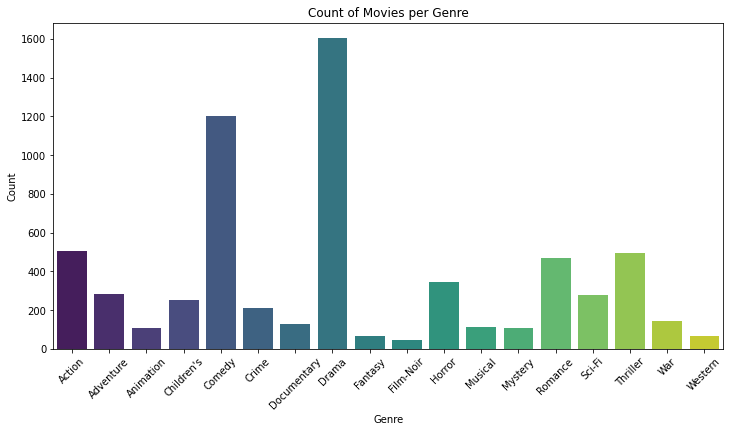

In [14]:
# Sum the counts for each genre
genre_counts = movies_df.iloc[:, 3:].sum()  # Assuming genre columns start at the 4th column

# Convert to a DataFrame for easier plotting
genre_counts_df = genre_counts.reset_index()
genre_counts_df.columns = ["Genre", "Count"]

# Plot the countplot
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_counts_df, x="Genre", y="Count", palette="viridis")
plt.title("Count of Movies per Genre")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Users Dataset

In [15]:
print('Users Dataset:')
users_df.head()

Users Dataset:


,user_id,sex,age_group,occupation,zip_code
0,user_1,F,group_1,occupation_10,48067
1,user_2,M,group_56,occupation_16,70072
2,user_3,M,group_25,occupation_15,55117
3,user_4,M,group_45,occupation_7,02460
4,user_5,M,group_25,occupation_20,55455


In [16]:
users_df.describe()

,user_id,sex,age_group,occupation,zip_code
count,6040,6040,6040,6040,6040
unique,6040,2,7,21,3439
top,user_1,M,group_25,occupation_4,48104
freq,1,4331,2096,759,19


In [17]:
users_df.isnull().sum()/len(users_df)*100

user_id       0.0
sex           0.0
age_group     0.0
occupation    0.0
zip_code      0.0
dtype: float64

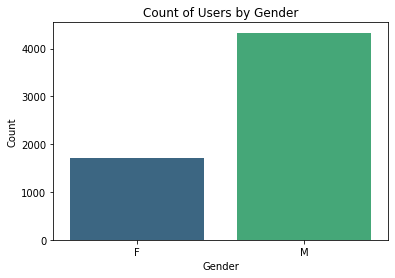

In [18]:
# Countplot for gender
plt.figure(figsize=(6, 4))
sns.countplot(data=users_df, x="sex", palette="viridis")
plt.title("Count of Users by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

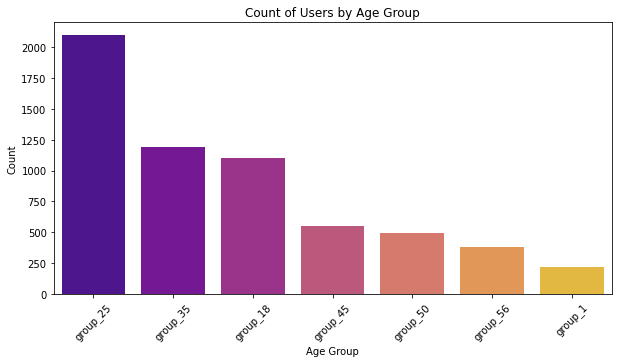

In [19]:
# Countplot for age groups
plt.figure(figsize=(10, 5))
sns.countplot(data=users_df, x="age_group", order=users["age_group"].value_counts().index, palette="plasma")
plt.title("Count of Users by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

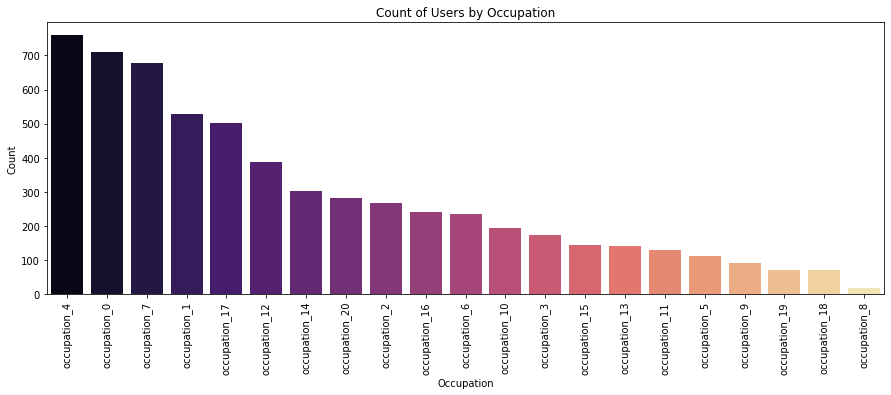

In [20]:
# Countplot for occupation
plt.figure(figsize=(15, 5))
sns.countplot(data=users_df, x="occupation", order=users["occupation"].value_counts().index, palette="magma")
plt.title("Count of Users by Occupation")
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

## Step 2: Transform the Movie Ratings into Sequences

In [21]:
# Group by user_id and sort by timestamp
ratings_group = ratings.sort_values(by=["unix_timestamp"]).groupby("user_id")
ratings_data = pd.DataFrame({
    "user_id": list(ratings_group.groups.keys()),
    "movie_ids": list(ratings_group.movie_id.apply(list)),
    "ratings": list(ratings_group.rating.apply(list)),
})

# Define sequence parameters
sequence_length = 10
step_size = 2

# Function to create sequences
def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            break
        sequences.append(seq)
        start_index += step_size
    return sequences

# Apply sequence creation to movie IDs and ratings
ratings_data["sequence_movie_ids"] = ratings_data["movie_ids"].apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)
ratings_data["sequence_ratings"] = ratings_data["ratings"].apply(
    lambda ratings: create_sequences(ratings, sequence_length, step_size)
)

# Drop unused columns
ratings_data = ratings_data.explode(["sequence_movie_ids", "sequence_ratings"]).dropna()

# Add target movie ID and rating
ratings_data["target_movie_id"] = ratings_data["sequence_movie_ids"].apply(lambda seq: seq[-1])
ratings_data["target_rating"] = ratings_data["sequence_ratings"].apply(lambda seq: seq[-1])

# Drop the last elements from sequences
ratings_data["sequence_movie_ids"] = ratings_data["sequence_movie_ids"].apply(lambda seq: seq[:-1])
ratings_data["sequence_ratings"] = ratings_data["sequence_ratings"].apply(lambda seq: seq[:-1])

# Inspect resulting DataFrame
print(ratings_data.head())

  user_id                                          movie_ids  \
0  user_1  [movie_3186, movie_1721, movie_1270, movie_102...   
0  user_1  [movie_3186, movie_1721, movie_1270, movie_102...   
0  user_1  [movie_3186, movie_1721, movie_1270, movie_102...   
0  user_1  [movie_3186, movie_1721, movie_1270, movie_102...   
0  user_1  [movie_3186, movie_1721, movie_1270, movie_102...   

                                             ratings  \
0  [4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 4.0, 5.0, ...   
0  [4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 4.0, 5.0, ...   
0  [4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 4.0, 5.0, ...   
0  [4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 4.0, 5.0, ...   
0  [4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 4.0, 5.0, ...   

                                  sequence_movie_ids  \
0  [movie_3186, movie_1721, movie_1270, movie_102...   
0  [movie_1270, movie_1022, movie_2340, movie_183...   
0  [movie_2340, movie_1836, movie_3408, movie_120...   
0  [movie_3408, movie_1207, movie_2804, movie_260...  

## Step 3: Define Metadata

In [22]:
# Define the correct header for the CSV files
CSV_HEADER = [
    "user_id",
    "movie_ids",
    "ratings",
    "sequence_movie_ids",
    "sequence_ratings",
    "target_movie_id",
    "target_rating"
]

# Verify the metadata matches the columns
print(f"CSV Header: {CSV_HEADER}")

CSV Header: ['user_id', 'movie_ids', 'ratings', 'sequence_movie_ids', 'sequence_ratings', 'target_movie_id', 'target_rating']


In [23]:
# Define the header for the transformed sequences DataFrame
CSV_HEADER = [
    "user_id",
    "movie_ids",
    "ratings",
    "sequence_movie_ids",
    "sequence_ratings",
    "target_movie_id",
    "target_rating"
]

# Define vocabularies for categorical features
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(users_df["user_id"].unique()),
    "movie_ids": list(movies_df["movie_id"].unique()),
}

# User features (keep it relevant if `sex`, `age_group`, and `occupation` are used)
USER_FEATURES = ["sex", 'age_group', 'occupation']

# Movie features (retain only if genres or similar are required)
MOVIE_FEATURES = ['genres']

# Define sequence length (this must match the sequence length used in the sequences step)
sequence_length = 6  # Example: The length of each sequence

# Display the metadata information for verification
print("Metadata Information:")
print()
print(f"CSV Header: {CSV_HEADER}")
print()
print("Categorical Features with Vocabulary:")
for feature, vocab in CATEGORICAL_FEATURES_WITH_VOCABULARY.items():
    print(f" - {feature}: {len(vocab)} unique values")
print()
print(f"User Features: {USER_FEATURES}")
print(f"Movie Features: {MOVIE_FEATURES}")
print(f"Sequence Length: {sequence_length}")

Metadata Information:

CSV Header: ['user_id', 'movie_ids', 'ratings', 'sequence_movie_ids', 'sequence_ratings', 'target_movie_id', 'target_rating']

Categorical Features with Vocabulary:
 - user_id: 6040 unique values
 - movie_ids: 3883 unique values

User Features: ['sex', 'age_group', 'occupation']
Movie Features: ['genres']
Sequence Length: 6


## Step 4: Create a Dataset for Training and Evaluation

In [24]:
def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    def process(features):
        movie_ids_string = features["sequence_movie_ids"]
        sequence_movie_ids = tf.strings.split(movie_ids_string, ",").to_tensor()

        # The last movie id in the sequence is the target movie.
        features["target_movie_id"] = sequence_movie_ids[:, -1]
        features["sequence_movie_ids"] = sequence_movie_ids[:, :-1]

        ratings_string = features["sequence_ratings"]
        sequence_ratings = tf.strings.to_number(
            tf.strings.split(ratings_string, ","), tf.dtypes.float32
        ).to_tensor()

        # The last rating in the sequence is the target for the model to predict.
        target = sequence_ratings[:, -1]
        features["sequence_ratings"] = sequence_ratings[:, :-1]

        return features, target

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        num_epochs=5,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    ).map(process)

    return dataset

## Step 5: Create Model Inputs

In [25]:
def create_model_inputs(sequence_length):
    """
    Function to create a dictionary of input layers for the model.
    """
    model_inputs = {
        "user_id": tf.keras.Input(name="user_id", shape=(1,), dtype="string"),
        "sequence_movie_ids": tf.keras.Input(name="sequence_movie_ids", shape=(sequence_length - 1,), dtype="string"),
        "target_movie_id": tf.keras.Input(name="target_movie_id", shape=(1,), dtype="string"),
        "sequence_ratings": tf.keras.Input(name="sequence_ratings", shape=(sequence_length - 1,), dtype=tf.float32),
        "sex": tf.keras.Input(name="sex", shape=(1,), dtype="string"),
        "age_group": tf.keras.Input(name="age_group", shape=(1,), dtype="string"),
        "occupation": tf.keras.Input(name="occupation", shape=(1,), dtype="string"),
    }
    return model_inputs

# Example usage
inputs = create_model_inputs(sequence_length=sequence_length)
for key, value in inputs.items():
    print(f"{key}: {value}")

user_id: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='user_id'), name='user_id', description="created by layer 'user_id'")
sequence_movie_ids: KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.string, name='sequence_movie_ids'), name='sequence_movie_ids', description="created by layer 'sequence_movie_ids'")
target_movie_id: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='target_movie_id'), name='target_movie_id', description="created by layer 'target_movie_id'")
sequence_ratings: KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name='sequence_ratings'), name='sequence_ratings', description="created by layer 'sequence_ratings'")
sex: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='sex'), name='sex', description="created by layer 'sex'")
age_group: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='age_group'), name='age_group', description="created by layer 'ag

## Step 6: Create a BST Model

In [26]:
def create_bst_model(
    include_user_id=False,
    include_user_features=False,
    include_movie_features=False,
    hidden_units=[256, 128],
    dropout_rate=0.1,
    num_heads=3,
    sequence_length=6,  # Default sequence length
):
    # Define model inputs
    inputs = create_model_inputs(sequence_length=sequence_length)

    # Encode input features
    transformer_features, other_features = encode_input_features(
        inputs,
        include_user_id=include_user_id,
        include_user_features=include_user_features,
        include_movie_features=include_movie_features,
    )

    # Create a multi-headed attention layer
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=transformer_features.shape[2],
        dropout=dropout_rate,
    )(transformer_features, transformer_features)

    # Transformer block
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    x1 = layers.Add()([transformer_features, attention_output])
    x1 = layers.LayerNormalization()(x1)
    x1 = layers.LeakyReLU()(x1)
    x2 = layers.Dense(units=x1.shape[-1])(x1)
    x2 = layers.Dropout(dropout_rate)(x2)
    transformer_features = layers.Add()([x1, x2])
    transformer_features = layers.LayerNormalization()(transformer_features)
    features = layers.Flatten()(transformer_features)

    # Include additional user or movie features
    if other_features is not None:
        features = layers.concatenate(
            [features, layers.Reshape(target_shape=(other_features.shape[-1],))(other_features)]
        )

    # Fully connected layers
    for num_units in hidden_units:
        features = layers.Dense(units=num_units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.LeakyReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    # Output layer
    outputs = layers.Dense(units=1)(features)

    # Create and return the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [27]:
from tensorflow.keras import layers

def encode_input_features(inputs, include_user_id=False, include_user_features=False, include_movie_features=False):
    encoded_transformer_features = None
    encoded_other_features = None

    # Example for handling user_id
    if include_user_id and 'user_id' in inputs:
        user_id_input = inputs['user_id']
        user_id_embedding = layers.Embedding(input_dim=1000, output_dim=32)(user_id_input)
        encoded_transformer_features = user_id_embedding  # Assign to transformer features

    # Example for handling user_features
    if include_user_features and 'user_features' in inputs:
        user_features_input = inputs['user_features']
        user_features_dense = layers.Dense(32, activation='relu')(user_features_input)
        encoded_other_features = user_features_dense  # Assign to other features

    # Example for handling movie_features
    if include_movie_features and 'movie_features' in inputs:
        movie_features_input = inputs['movie_features']
        movie_features_embedding = layers.Embedding(input_dim=5000, output_dim=64)(movie_features_input)
        encoded_transformer_features = movie_features_embedding  # Update transformer features

    # Return encoded features
    return encoded_transformer_features, encoded_other_features

In [28]:
sequence_length = 6  # Set your sequence length

inputs = create_model_inputs(sequence_length=sequence_length)
encoded_transformer_features, encoded_other_features = encode_input_features(
    inputs,
    include_user_id=True,
    include_user_features=True,
    include_movie_features=True,
)

## Step 7: Run Training and Evaluation Experiment

In [29]:
def create_bst_model(include_user_id, include_user_features, include_movie_features, hidden_units, dropout_rate, num_heads, sequence_length):
    from tensorflow.keras import layers, Model

    # Input layer
    inputs = create_model_inputs(sequence_length=sequence_length)

    # Embedding layers for user, movie, and other features
    encoded_transformer_features, encoded_other_features = encode_input_features(
        inputs,
        include_user_id=include_user_id,
        include_user_features=include_user_features,
        include_movie_features=include_movie_features,
    )

    # If other features are encoded, concatenate with transformer features
    if encoded_other_features:
        encoded_features = layers.Concatenate(axis=1)([encoded_transformer_features, encoded_other_features])
    else:
        encoded_features = encoded_transformer_features

    # Transformer encoder
    transformer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=sequence_length)(encoded_features, encoded_features)
    transformer = layers.LayerNormalization()(transformer)
    transformer = layers.Dropout(rate=dropout_rate)(transformer)
    transformer = layers.Dense(units=sequence_length, activation="relu")(transformer)

    # Flatten features for fully connected layers
    features = layers.Flatten()(transformer)

    # Fully connected layers
    for num_units in hidden_units:  # hidden_units should now be a list of integers
        features = layers.Dense(units=num_units, activation="relu")(features)
        features = layers.BatchNormalization()(features)
        features = layers.Dropout(rate=dropout_rate)(features)

    # Output layer for the final prediction
    outputs = layers.Dense(units=1, activation="linear")(features)

    # Create and return the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Function to compile and train the model
def run_training_and_evaluation(model, train_data_path, test_data_path, batch_size, epochs):
    from tensorflow.keras import optimizers, losses, metrics

    # Compile the model
    model.compile(
        optimizer=optimizers.Adagrad(learning_rate=0.01),
        loss=losses.MeanSquaredError(),
        metrics=[metrics.MeanAbsoluteError()],
    )
    print("Model compiled successfully!")

    # Load training data
    train_dataset = get_dataset_from_csv(train_data_path, shuffle=True, batch_size=batch_size)
    print("Training dataset loaded!")

    # Fit the model
    model.fit(train_dataset, epochs=epochs)
    print("Model training completed!")

    # Load testing data
    test_dataset = get_dataset_from_csv(test_data_path, shuffle=False, batch_size=batch_size)
    print("Testing dataset loaded!")

    # Evaluate the model
    _, mae = model.evaluate(test_dataset, verbose=0)
    print(f"Test MAE: {round(mae, 3)}")

    return model

# Example usage
train_data_path = "train_data.csv"
test_data_path = "test_data.csv"

# Adjusted model creation call
bst_model = create_bst_model(
    include_user_id=True,
    include_user_features=True,
    include_movie_features=True,
    hidden_units=[32, 16],  # List of integers for fully connected layers
    dropout_rate=0.2,
    num_heads=4,
    sequence_length=6  # Adjust sequence length as per your data
)

# Run the training and evaluation
run_training_and_evaluation(bst_model, train_data_path, test_data_path, batch_size=128, epochs=5)


Model compiled successfully!


ValueError: Problem inferring types: CSV row 1 has 5 number of fields. Expected: 7.